# 🎤 Gender Classification from Speech using Machine Learning

This notebook demonstrates how to build a machine learning pipeline for **speech classification** — specifically, classifying whether a speaker is male or female based on their voice recordings.

We'll walk through the following steps:

---

## 📌 Objectives

- Preprocess audio data to improve quality and consistency.
- Extract relevant features from speech signals.
- Train a machine learning model (Logistic Regression) for classification.
- Evaluate model performance using accuracy and classification metrics.

---

## 🛠️ Techniques Used

### 🔉 Audio Preprocessing
- **Trimming**: Remove silence from the beginning and end of the audio.
- **Normalization**: Ensure audio levels are consistent across files.
- **Resampling**: Convert all files to a consistent sampling rate.
- **Padding/Truncating**: Ensure all inputs have the same length.

### 📊 Feature Extraction
We extract powerful features that capture characteristics of the speaker’s voice:
- **MFCCs (Mel-Frequency Cepstral Coefficients)**: Capture timbral and phonetic content.
- **Spectral Centroid**: Measures the "center of mass" of frequencies.
- **Spectral Rolloff**: Frequency below which a set percentage (e.g., 85%) of the energy is contained.
- **Zero-Crossing Rate**: Counts how often the signal changes sign — higher for noisy or unvoiced sounds.
- **RMS Energy**: Captures the loudness of the signal.

---

## 🧠 Model
We use a **Logistic Regression** model to classify audio based on extracted features. The model is trained on labeled examples of male and female voices.

---

## 📈 Evaluation
The final model is evaluated using:
- **Accuracy**
- **Precision, Recall, F1-Score**
- **Confusion Matrix**

---

Let's get started!


In [1]:
%pip install noisereduce

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Importing Libraries

In [2]:
# Standard Library
import os
from collections import Counter

# Numerical and Data Processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Audio Processing
import librosa
import librosa.effects
import noisereduce as nr
import IPython.display as ipd

# Machine Learning Models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

# Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Model Utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.decomposition import PCA

# Experimenting on a Sample

let's take a sample and use it in experimenting and visualizing 

In [3]:
sample ='data/female/arctic_b0454.wav'

# Audio Processing

## 1. Load Audio File

In [4]:
ipd.Audio(sample)

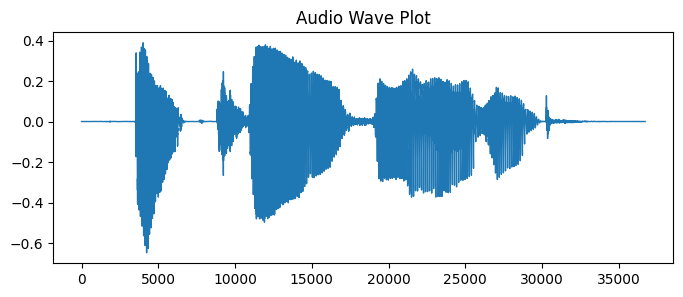

In [5]:
x, sr = librosa.load(sample)

pd.Series(x).plot(figsize=(8, 3), lw=1)
plt.title('Audio Wave Plot')
plt.show()

## 2. ✂️ Trim Silence
Removes unnecessary silence from the beginning and end of the audio. This helps eliminate parts of the audio that contain no useful information.

We use `librosa.effects.trim()` function with a parameter `top_db` which stands for "how many decibels below the peak" should be considered silence.

"Decibels" is a logarithmic unit used to measure sound level.

* Lower `top_db` (e.g., `20`) → stricter silence removal (only trims very quiet parts).
* Higher `top_db` (e.g., `60`) → more aggressive (trims even moderately quiet parts).

We will choose `35` which is somewhat in the middle

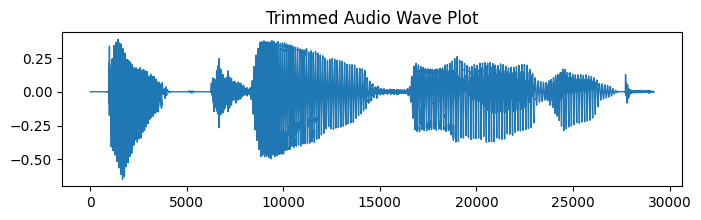

In [6]:
trimmed_x, index = librosa.effects.trim(x, top_db=35)
pd.Series(trimmed_x).plot(figsize=(8, 2), lw=1)
plt.title('Trimmed Audio Wave Plot')
plt.show()

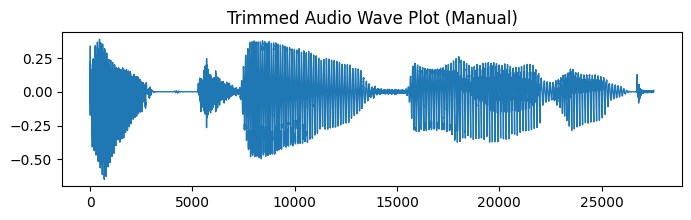

In [7]:
def manual_trim_silence(audio_data, threshold=0.01):
    start_index = 0
    for i in range(len(audio_data)):
        if abs(audio_data[i]) > threshold:
            start_index = i
            break
    end_index = len(audio_data) - 1
    for i in range(len(audio_data) - 1, -1, -1):
        if abs(audio_data[i]) > threshold:
            end_index = i
            break
    return audio_data[start_index : end_index + 1]

# Misal x sudah berisi data audio
trimmed_manual = manual_trim_silence(x, threshold=0.01)

# Plot hasil trim manual
pd.Series(trimmed_manual).plot(figsize=(8, 2), lw=1)
plt.title('Trimmed Audio Wave Plot (Manual)')
plt.show()

## 3. 🧼 Noise Reduction

Reduces background noise such as hums, hisses, or ambient sounds using filters or noise reduction algorithms.

* High-pass filters remove low-frequency noise.
* `noisereduce` library can automatically detect and reduce noise.

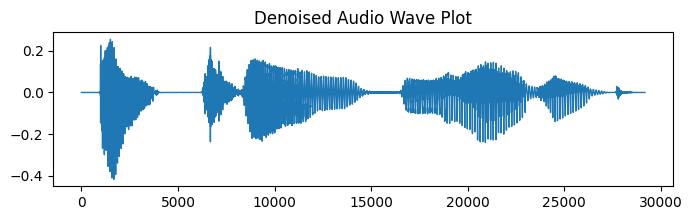

In [8]:
import noisereduce as nr

denoised_x = nr.reduce_noise(y=trimmed_x, sr=sr)

pd.Series(denoised_x).plot(figsize=(8, 2), lw=1)
plt.title('Denoised Audio Wave Plot')
plt.show()

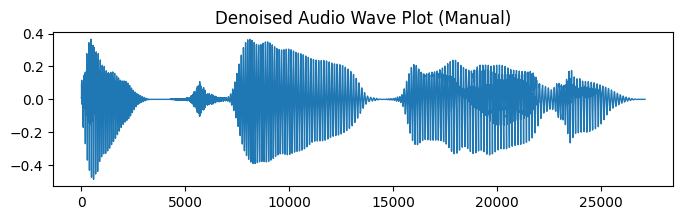

In [9]:
def manual_spectral_gating(audio_data, sr, noise_len=5000, n_fft=2048, hop_length=512, reduction_db=15):
    # 1. Noise profile
    noise_clip = audio_data[:noise_len]
    # 2. STFT
    audio_stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
    noise_stft = librosa.stft(noise_clip, n_fft=n_fft, hop_length=hop_length)
    # 3. Rata-rata spektrum noise
    noise_mag = np.abs(noise_stft)
    noise_profile = np.mean(noise_mag, axis=1, keepdims=True)
    # 4. Masking
    audio_mag = np.abs(audio_stft)
    audio_phase = np.angle(audio_stft)
    threshold = noise_profile + librosa.db_to_amplitude(reduction_db)
    mask = audio_mag >= threshold
    audio_mag_denoised = audio_mag * mask
    # 5. ISTFT
    audio_stft_denoised = audio_mag_denoised * np.exp(1j * audio_phase)
    denoised_audio = librosa.istft(audio_stft_denoised, hop_length=hop_length)
    return denoised_audio

denoised_manual = manual_spectral_gating(trimmed_manual, sr)

# Plot hasil denoise manual
pd.Series(denoised_manual).plot(figsize=(8, 2), lw=1)
plt.title('Denoised Audio Wave Plot (Manual)')
plt.show()

## 4. 📈 Normalization

Ensures all audio signals are on the same volume scale by scaling the waveform so its peak is consistent across samples.

In [10]:
normalized_x = librosa.util.normalize(denoised_x)

In [11]:
def manual_normalize_audio(audio_data):
    max_abs_amplitude = np.max(np.abs(audio_data))
    if max_abs_amplitude == 0:
        return audio_data
    return audio_data / max_abs_amplitude

## 5. ⏱️ Resampling (Optional)

Resamples all audio to the same sampling rate (e.g. 16,000 Hz), which ensures uniformity across the dataset.

Sample rate: how many samples per second are used to represent the audio.

In [12]:
resampled_x = librosa.resample(x, orig_sr=sr, target_sr=16000)

In [13]:
def manual_resample_audio(audio_data, original_sr, target_sr):
    if original_sr == target_sr:
        return audio_data
    original_length = len(audio_data)
    target_length = int(original_length * target_sr / original_sr)
    original_time = np.arange(original_length)
    target_time = np.linspace(0, original_length - 1, target_length)
    resampled_data = np.interp(target_time, original_time, audio_data)
    return resampled_data

## 6. 🧱 Padding or Truncating

Length of our audio sample (x): 36714
Length of our resized sample: 30000


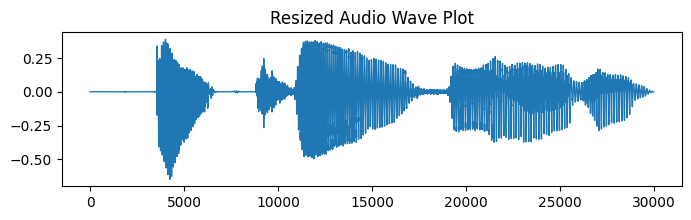

In [14]:
desired_length = 30000

print("Length of our audio sample (x):", len(x))
resized_x = x

if len(x) < desired_length:
    resized_x = np.pad(x, (0, desired_length - len(x)))
else:
    resized_x = x[:desired_length]

print('Length of our resized sample:', len(resized_x))
pd.Series(resized_x).plot(figsize=(8, 2), lw=1)
plt.title('Resized Audio Wave Plot')
plt.show()

Let's look the audio wave at a more zoomed level

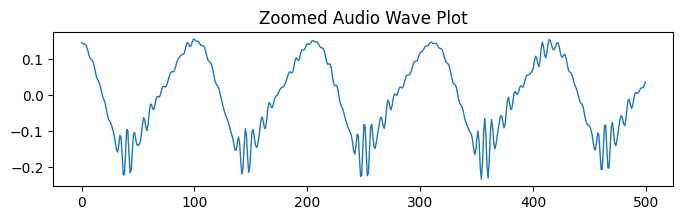

In [15]:
pd.Series(denoised_x[9000:9500]).plot(figsize=(8, 2), lw=1)
plt.title('Zoomed Audio Wave Plot')
plt.show()

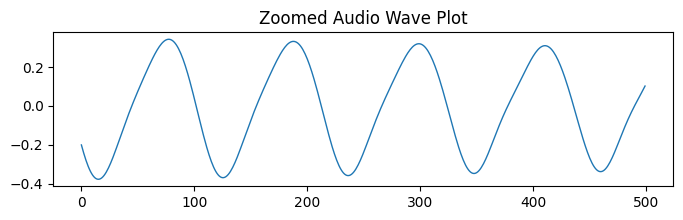

In [16]:
pd.Series(denoised_manual[9000:9500]).plot(figsize=(8, 2), lw=1)
plt.title('Zoomed Audio Wave Plot')
plt.show()

# Feature Extraction

Now let's look at various feature extraction techniques

## 1. 📊 Spectrogram

Shows how the frequencies of the audio signal change over time.

* **X-axis**: time
* **Y-axis**: frequency
* **Color**: amplitude (loudness) of each frequency at that moment

In [17]:
transformed_x = librosa.stft(trimmed_x)
db = librosa.amplitude_to_db(abs(transformed_x))
db.shape

(1025, 58)

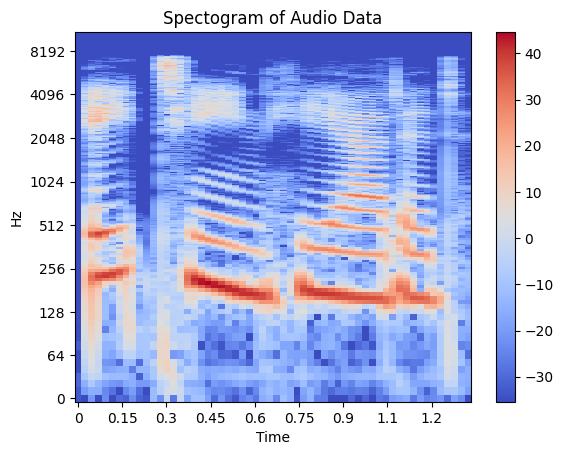

In [18]:
image = librosa.display.specshow(db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(image)
plt.title('Spectogram of Audio Data')
plt.show()

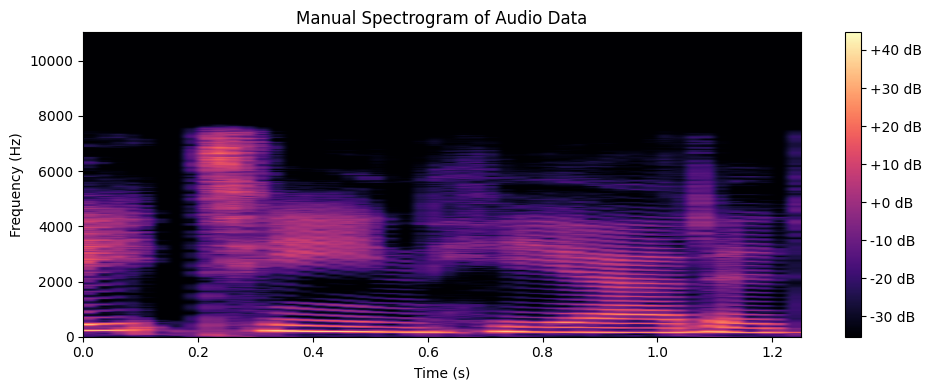

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def manual_stft(audio_data, frame_size=2048, hop_length=512, window_fn=np.hanning):
    """
    Manual STFT mirip librosa.stft (mengembalikan array kompleks).
    """
    audio_data = np.asarray(audio_data)
    if len(audio_data) < frame_size:
        audio_data = np.pad(audio_data, (0, frame_size - len(audio_data)), mode='constant')
    num_frames = 1 + int((len(audio_data) - frame_size) / hop_length)
    stft_matrix = np.empty((frame_size // 2 + 1, num_frames), dtype=np.complex64)
    window = window_fn(frame_size)
    for n in range(num_frames):
        start = n * hop_length
        frame = audio_data[start:start + frame_size] * window
        fft_result = np.fft.rfft(frame)
        stft_matrix[:, n] = fft_result
    return stft_matrix

def manual_amplitude_to_db(magnitude, ref=1.0, amin=1e-10, top_db=80.0):
    """
    Manual amplitude to dB conversion (mirip librosa.amplitude_to_db).
    """
    magnitude = np.maximum(amin, magnitude)
    db = 20.0 * np.log10(magnitude / ref)
    db = np.maximum(db, db.max() - top_db)
    return db

# --- Contoh penggunaan ---
# trimmed_x: audio 1D numpy array, sr: sample rate
frame_size = 2048
hop_length = 512

# Manual STFT
manual_stft_matrix = manual_stft(trimmed_manual, frame_size, hop_length)
manual_db = manual_amplitude_to_db(np.abs(manual_stft_matrix))

# Visualisasi manual spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(manual_db, aspect='auto', origin='lower', 
           extent=[0, len(trimmed_manual)/sr, 0, sr/2], cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Manual Spectrogram of Audio Data')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

## 2. 🎵 Mel Spectogram

Similar to a regular spectrogram, but the frequency axis is scaled to match how humans hear (the Mel scale).

It focuses more on low to mid frequencies, which are most important for speech and music.

In [20]:
S = librosa.feature.melspectrogram(y=x, sr=sr)

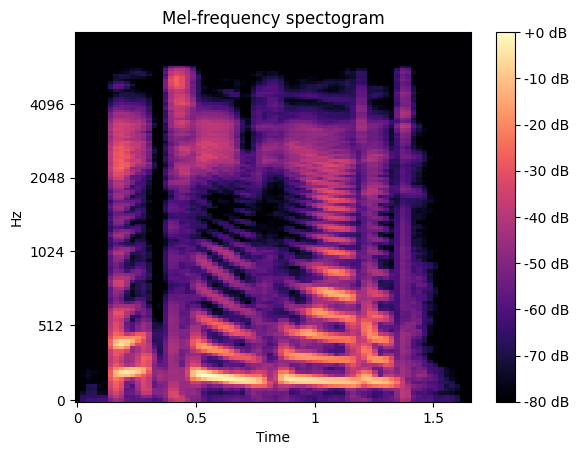

In [21]:
fig, ax = plt.subplots()
S_db = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_db, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectogram')
plt.show()

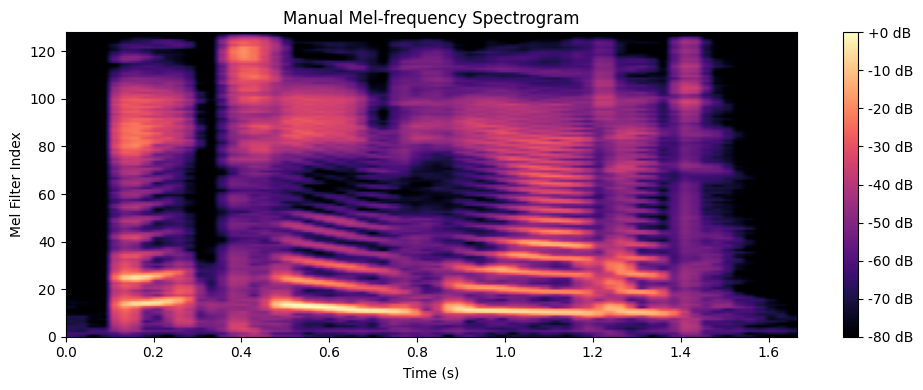

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def manual_stft(audio_data, frame_size=2048, hop_length=512, window_fn=np.hanning):
    audio_data = np.asarray(audio_data)
    if len(audio_data) < frame_size:
        audio_data = np.pad(audio_data, (0, frame_size - len(audio_data)), mode='constant')
    num_frames = 1 + int((len(audio_data) - frame_size) / hop_length)
    stft_matrix = np.empty((frame_size // 2 + 1, num_frames), dtype=np.complex64)
    window = window_fn(frame_size)
    for n in range(num_frames):
        start = n * hop_length
        frame = audio_data[start:start + frame_size] * window
        fft_result = np.fft.rfft(frame)
        stft_matrix[:, n] = fft_result
    return stft_matrix

def hz_to_mel(hz):
    return 2595 * np.log10(1 + hz / 700)

def mel_to_hz(mel):
    return 700 * (10**(mel / 2595) - 1)

def manual_mel_filter_bank(num_filters, n_fft, sr, fmin=0, fmax=None):
    if fmax is None:
        fmax = sr / 2
    min_mel = hz_to_mel(fmin)
    max_mel = hz_to_mel(fmax)
    mel_points = np.linspace(min_mel, max_mel, num_filters + 2)
    hz_points = mel_to_hz(mel_points)
    bin_points = np.floor((n_fft + 1) * hz_points / sr).astype(int)
    filter_bank = np.zeros((num_filters, int(n_fft // 2 + 1)))
    for i in range(num_filters):
        left = bin_points[i]
        center = bin_points[i+1]
        right = bin_points[i+2]
        if left < center:
            filter_bank[i, left:center] = (np.arange(left, center) - left) / (center - left)
        if center < right:
            filter_bank[i, center:right] = (right - np.arange(center, right)) / (right - center)
    return filter_bank

def manual_amplitude_to_db(magnitude, ref=1.0, amin=1e-10, top_db=80.0):
    magnitude = np.maximum(amin, magnitude)
    db = 10.0 * np.log10(magnitude / ref)
    db = np.maximum(db, db.max() - top_db)
    return db

# --- Manual Mel Spectrogram ---
n_fft = 2048
hop_length = 512
num_mels = 128

# 1. STFT
stft_matrix = manual_stft(x, frame_size=n_fft, hop_length=hop_length)
power_spec = np.abs(stft_matrix) ** 2

# 2. Mel Filter Bank
mel_fb = manual_mel_filter_bank(num_mels, n_fft, sr, fmin=0, fmax=8000)

# 3. Apply Mel Filter Bank
mel_spec = np.dot(mel_fb, power_spec)

# 4. Convert to dB
mel_spec_db = manual_amplitude_to_db(mel_spec, ref=np.max(mel_spec))

# 5. Plot
plt.figure(figsize=(10, 4))
plt.imshow(mel_spec_db, aspect='auto', origin='lower',
           extent=[0, len(x)/sr, 0, num_mels], cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Manual Mel-frequency Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Mel Filter Index')
plt.tight_layout()
plt.show()

## 3. 🎯 Spectral Centroid

The Spectral Centroid tells us where the "center of mass" of the sound frequencies is — it shows us how "bright" or "dark" a sound is.

* If most energy is in high frequencies, the centroid is high → the sound is bright or sharp (like cymbals).
* If most energy is in low frequencies, the centroid is low → the sound is dull or bassy (like drums or male voices).

In [23]:
cent = librosa.feature.spectral_centroid(y=x, sr=sr)
frames = range(len(cent))
time = librosa.frames_to_time(frames)
S, phase = librosa.magphase(librosa.stft(y=x))
freqs, times, D = librosa.reassigned_spectrogram(x, fill_nan=True)

C:\Users\Nadya\AppData\Local\Temp\ipykernel_12788\871606200.py:6: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 2 Axes> than <Figure size 640x480 with 2 Axes> which fig.colorbar is called on.
  fig.colorbar(img, ax=ax, format='%+2.0f dB')


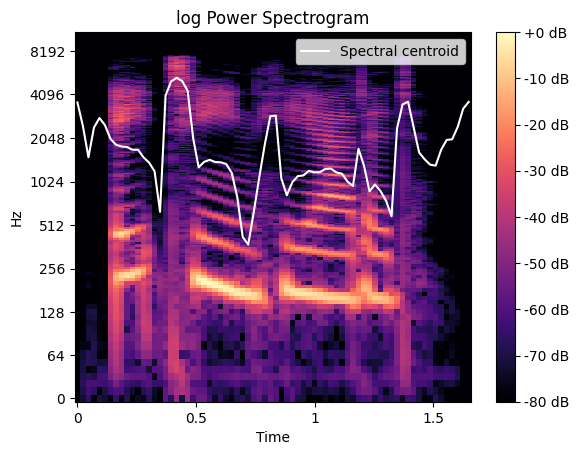

In [24]:
times = librosa.times_like(cent)
fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)
ax.plot(times, cent.T, label='Spectral centroid', color='w')
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.legend(loc='upper right')
ax.set(title='log Power Spectrogram')
plt.show()

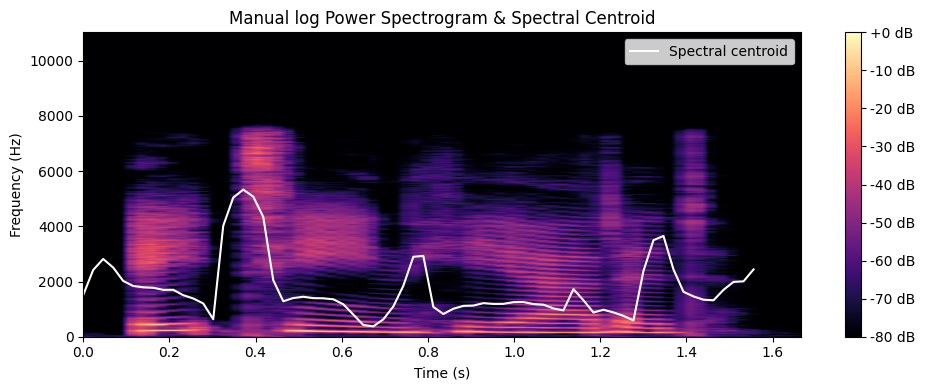

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# --- Manual STFT ---
def manual_stft(audio_data, frame_size=2048, hop_length=512, window_fn=np.hanning):
    audio_data = np.asarray(audio_data)
    if len(audio_data) < frame_size:
        audio_data = np.pad(audio_data, (0, frame_size - len(audio_data)), mode='constant')
    num_frames = 1 + int((len(audio_data) - frame_size) / hop_length)
    stft_matrix = np.empty((frame_size // 2 + 1, num_frames), dtype=np.complex64)
    window = window_fn(frame_size)
    for n in range(num_frames):
        start = n * hop_length
        frame = audio_data[start:start + frame_size] * window
        fft_result = np.fft.rfft(frame)
        stft_matrix[:, n] = fft_result
    return stft_matrix

def manual_amplitude_to_db(magnitude, ref=1.0, amin=1e-10, top_db=80.0):
    magnitude = np.maximum(amin, magnitude)
    db = 20.0 * np.log10(magnitude / ref)
    db = np.maximum(db, db.max() - top_db)
    return db

# --- Manual Spectral Centroid ---
def manual_spectral_centroid(stft_matrix, sr):
    freqs = np.linspace(0, sr/2, stft_matrix.shape[0])
    mag = np.abs(stft_matrix)
    centroid = np.sum(freqs[:, np.newaxis] * mag, axis=0) / (np.sum(mag, axis=0) + 1e-10)
    return centroid

# --- Manual plotting ---
n_fft = 2048
hop_length = 512

# 1. STFT
stft_matrix = manual_stft(x, frame_size=n_fft, hop_length=hop_length)
S = np.abs(stft_matrix)
S_db = manual_amplitude_to_db(S, ref=np.max(S))

# 2. Spectral Centroid
centroid = manual_spectral_centroid(stft_matrix, sr)

# 3. Time axis
times = np.arange(S.shape[1]) * hop_length / sr

# 4. Plot
plt.figure(figsize=(10, 4))
plt.imshow(S_db, aspect='auto', origin='lower',
           extent=[0, len(x)/sr, 0, sr/2], cmap='magma')
plt.plot(times, centroid, label='Spectral centroid', color='w')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Manual log Power Spectrogram & Spectral Centroid')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## 4. ⚡ Zero Crossings (ZCR)

Counts how often the waveform changes sign (+ to - or - to +).

* High ZCR → Noisy, sharp, or high-pitched sounds
* Low ZCR → Smooth, low, bassy sounds

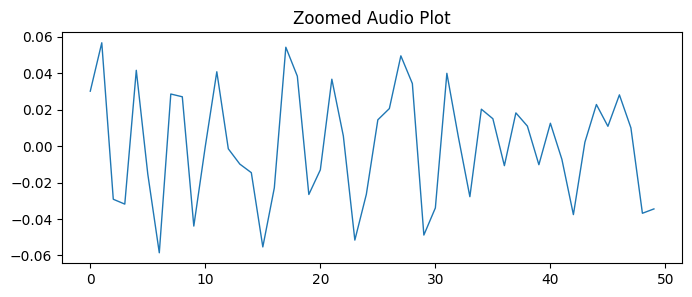

In [26]:
n0 = 10000
n1 = 10050
pd.Series(x[n0:n1]).plot(figsize = (8, 3), lw = 1)
plt.title("Zoomed Audio Plot")
plt.show()

In [27]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(zero_crossings.shape)
print("Number of Zero Crossings: ", sum(zero_crossings))

(50,)
Number of Zero Crossings:  23


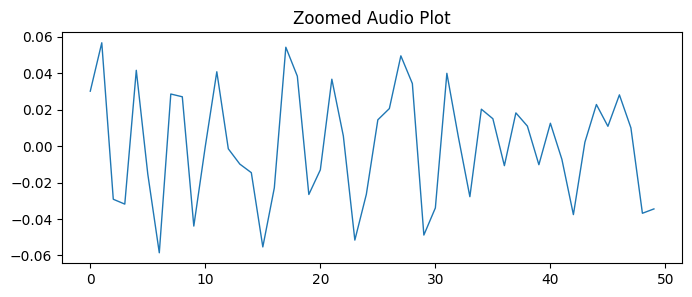

Zero crossing indices: [ 1  3  4  6  8 10 11 16 18 20 22 24 28 30 32 33 35 36 38 39 40 42 47]
Number of Zero Crossings: 23


In [28]:
n0 = 10000
n1 = 10050
pd.Series(x[n0:n1]).plot(figsize = (8, 3), lw = 1)
plt.title("Zoomed Audio Plot")
plt.show()

# Manual zero crossing calculation
def manual_zero_crossings(signal):
    # Hitung perubahan tanda (sign) antara sampel bertetangga
    signs = np.sign(signal)
    zero_crossings = np.where(np.diff(signs))[0]
    return zero_crossings

segment = x[n0:n1]
zc_indices = manual_zero_crossings(segment)
print("Zero crossing indices:", zc_indices)
print("Number of Zero Crossings:", len(zc_indices))

## 5. 🌊 Spectral Rolloff

Tells us the frequency, where below this frequency (point) is 85% of the total energy (amplitude) in the sound.

#### Example:
🧔 Male Voice (Deep, Low-pitched)

* Most energy is in low frequencies.
* We might reach 85% of the energy by 2000 Hz.
* ✅ So the Spectral Rolloff is low.

👩 Female Voice (High-pitched)

* Energy is spread into higher frequencies.
* We may need to go up to 5000 Hz to reach 85% of the energy.
* ✅ So the Spectral Rolloff is higher.

In [29]:
rolloff = librosa.feature.spectral_rolloff(y=x, sr=sr)[0]
print('Rolloff Shape:', rolloff.shape)

Rolloff Shape: (72,)


In [30]:
def manual_spectral_rolloff(y, sr, n_fft=2048, hop_length=512, roll_percent=0.85):
    # 1. STFT pakai manual_stft
    stft = np.abs(manual_stft(y, frame_size=n_fft, hop_length=hop_length))**2
    # 2. Total energy per frame
    energy = np.sum(stft, axis=0)
    # 3. Cumulative energy per frame
    cumulative_energy = np.cumsum(stft, axis=0)
    # 4. Find rolloff frequency bin for each frame
    rolloff_bin = np.argmax(cumulative_energy >= roll_percent * energy, axis=0)
    # 5. Convert bin to frequency (Hz)
    freqs = np.linspace(0, sr/2, stft.shape[0])
    rolloff = freqs[rolloff_bin]
    return rolloff

rolloff_manual = manual_spectral_rolloff(x, sr)
print('Manual Rolloff Shape:', rolloff_manual.shape)

Manual Rolloff Shape: (68,)


## 6. 🎼 MFCC (Mel-Frequency Cepstral Coefficients)
Captures the overall shape of the audio spectrum in a way that mimics human hearing. Commonly used in speech and music analysis.

MFCCs Shape: (20, 72)


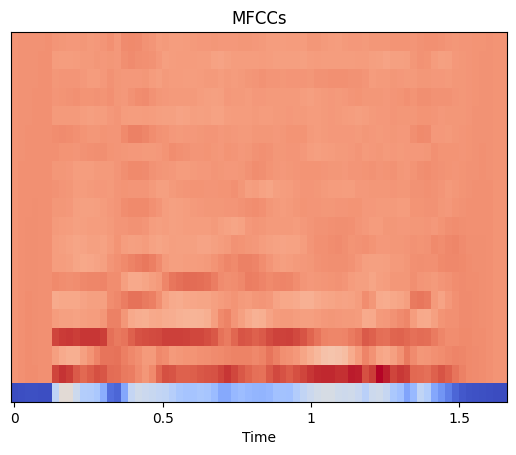

In [31]:
mfccs = librosa.feature.mfcc(y=x, sr=sr)
print("MFCCs Shape:", mfccs.shape)

librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.title('MFCCs')
plt.show()

Step 1 - Power Spectrogram shape: (1025, 68)


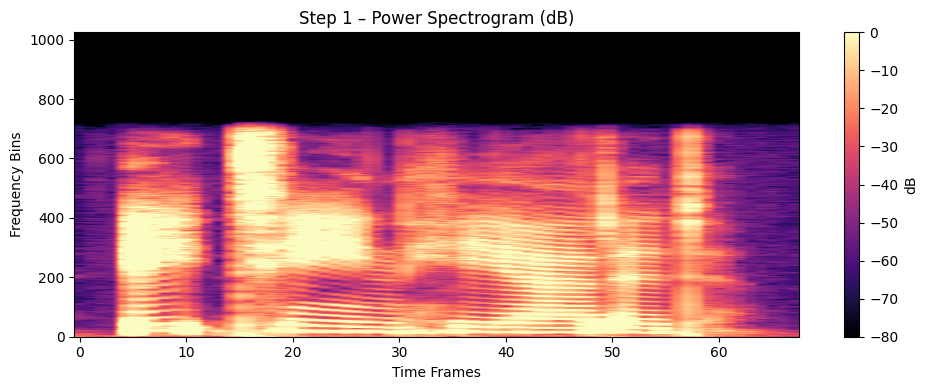

Step 2 - Mel Spectrogram shape: (40, 68)


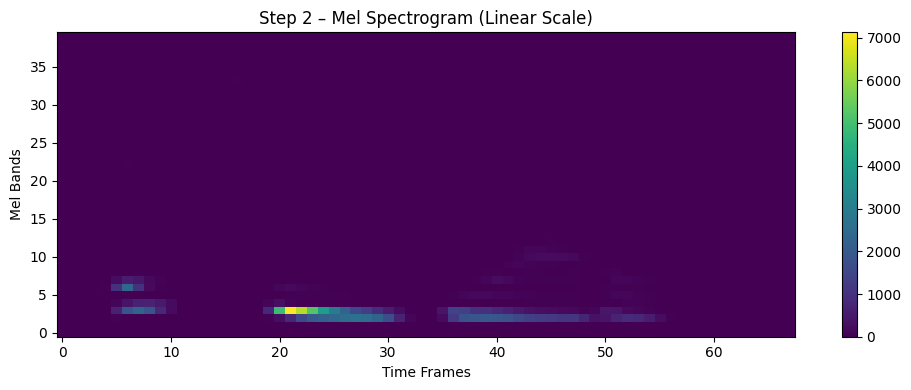

Step 3 - Log Mel Spectrogram shape: (40, 68)


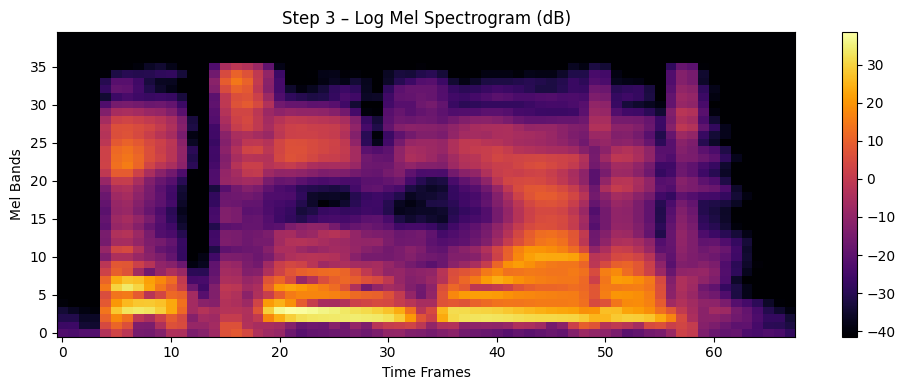

Step 4 - MFCC shape: (13, 68)


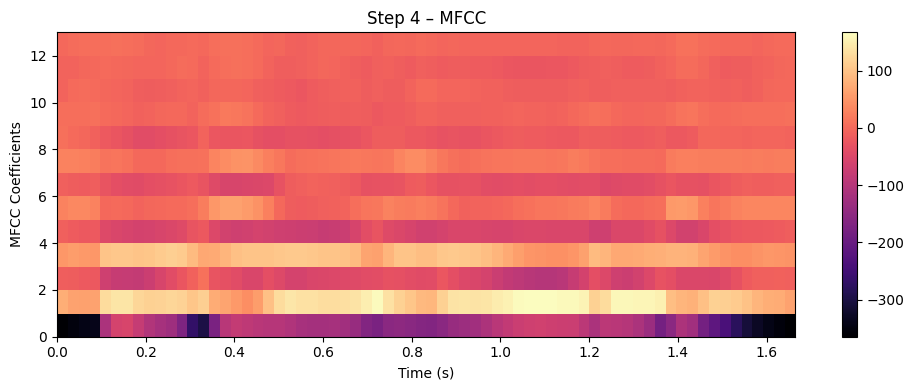

MFCCs Manual Shape: (13, 68)


In [35]:
import numpy as np
import matplotlib.pyplot as plt

# 1. DCT (Type II)
def manual_dct(x, type=2, norm='ortho'):
    N = x.shape[0]
    X = np.zeros_like(x)
    for k in range(N):
        X[k] = np.sum(x * np.cos(np.pi * k * (2 * np.arange(N) + 1) / (2 * N)))
    if norm == 'ortho':
        X[0] *= 1/np.sqrt(N)
        X[1:] *= np.sqrt(2/N)
    return X

# 2. STFT
def manual_stft(y, frame_size=2048, hop_length=512):
    window = np.hanning(frame_size)
    num_frames = 1 + (len(y) - frame_size) // hop_length
    stft_matrix = np.empty((frame_size // 2 + 1, num_frames), dtype=np.complex64)

    for i in range(num_frames):
        start = i * hop_length
        frame = y[start:start + frame_size]
        if len(frame) < frame_size:
            frame = np.pad(frame, (0, frame_size - len(frame)))  # zero padding
        frame = frame * window
        spectrum = np.fft.rfft(frame, n=frame_size)
        stft_matrix[:, i] = spectrum
    return stft_matrix

# 3. Mel Filter Bank
def hz_to_mel(hz):
    return 2595 * np.log10(1 + hz / 700)

def mel_to_hz(mel):
    return 700 * (10**(mel / 2595) - 1)

def manual_mel_filter_bank(n_mels, n_fft, sr, fmin=0, fmax=None):
    if fmax is None:
        fmax = sr / 2

    mel_points = np.linspace(hz_to_mel(fmin), hz_to_mel(fmax), n_mels + 2)
    hz_points = mel_to_hz(mel_points)
    bin_points = np.floor((n_fft + 1) * hz_points / sr).astype(int)

    filter_bank = np.zeros((n_mels, n_fft // 2 + 1))
    for m in range(1, n_mels + 1):
        f_left = bin_points[m - 1]
        f_center = bin_points[m]
        f_right = bin_points[m + 1]

        if f_center > f_left:
            filter_bank[m - 1, f_left:f_center] = (
                (np.arange(f_left, f_center) - f_left) / (f_center - f_left)
            )
        if f_right > f_center:
            filter_bank[m - 1, f_center:f_right] = (
                (f_right - np.arange(f_center, f_right)) / (f_right - f_center)
            )

    # Normalize each filter to sum to 1
    filter_bank /= np.sum(filter_bank, axis=1, keepdims=True) + 1e-10
    return filter_bank

# 4. Full MFCC Pipeline
def manual_mfcc(y, sr, n_mfcc=13, n_fft=2048, hop_length=512, n_mels=128, fmin=0, fmax=None):
    # Step 1: STFT → Power Spectrogram
    stft_matrix = manual_stft(y, frame_size=n_fft, hop_length=hop_length)
    S = np.abs(stft_matrix) ** 2
    print("Step 1 - Power Spectrogram shape:", S.shape)

    plt.figure(figsize=(10, 4))
    plt.imshow(10 * np.log10(S + 1e-10), aspect='auto', origin='lower',
               cmap='magma', vmin=-80, vmax=0)
    plt.title('Step 1 – Power Spectrogram (dB)')
    plt.xlabel('Time Frames')
    plt.ylabel('Frequency Bins')
    plt.colorbar(label='dB')
    plt.tight_layout()
    plt.show()

    # Step 2: Mel Filter Bank → Mel Spectrogram
    mel_fb = manual_mel_filter_bank(n_mels, n_fft, sr, fmin, fmax)
    mel_spec = np.dot(mel_fb, S)
    print("Step 2 - Mel Spectrogram shape:", mel_spec.shape)

    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spec, aspect='auto', origin='lower', cmap='viridis')
    plt.title('Step 2 – Mel Spectrogram (Linear Scale)')
    plt.xlabel('Time Frames')
    plt.ylabel('Mel Bands')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    # Step 3: Convert to dB
    log_mel_spec = 10 * np.log10(mel_spec + 1e-10)
    print("Step 3 - Log Mel Spectrogram shape:", log_mel_spec.shape)

    plt.figure(figsize=(10, 4))
    plt.imshow(log_mel_spec, aspect='auto', origin='lower',
               cmap='inferno', vmin=log_mel_spec.max() - 80, vmax=log_mel_spec.max())
    plt.title('Step 3 – Log Mel Spectrogram (dB)')
    plt.xlabel('Time Frames')
    plt.ylabel('Mel Bands')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    # Step 4: DCT → MFCC
    mfccs = np.apply_along_axis(lambda x: manual_dct(x, type=2, norm='ortho')[:n_mfcc],
                                 axis=0, arr=log_mel_spec)
    print("Step 4 - MFCC shape:", mfccs.shape)

    plt.figure(figsize=(10, 4))
    plt.imshow(mfccs, aspect='auto', origin='lower', cmap='magma',
               extent=[0, len(y)/sr, 0, n_mfcc])
    plt.title('Step 4 – MFCC')
    plt.xlabel('Time (s)')
    plt.ylabel('MFCC Coefficients')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    return mfccs

mfccs_manual = manual_mfcc(x, sr, n_mfcc=13, n_fft=2048, hop_length=512, n_mels=40)
print("MFCCs Manual Shape:", mfccs_manual.shape)

Manual MFCCs Shape: (13, 68)


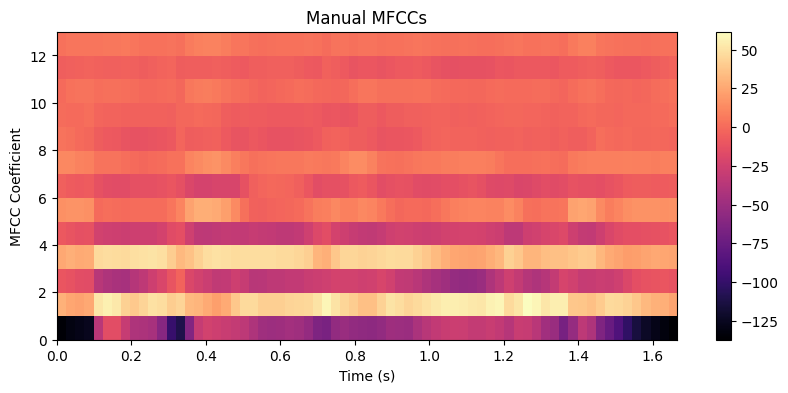

In [32]:
def manual_dct(x, type=2, norm='ortho'):
    # DCT type II, like scipy.fftpack.dct(x, type=2, norm='ortho')
    N = x.shape[0]
    X = np.zeros_like(x)
    for k in range(N):
        X[k] = np.sum(x * np.cos(np.pi * k * (2 * np.arange(N) + 1) / (2 * N)))
    if norm == 'ortho':
        X[0] *= 1/np.sqrt(N)
        X[1:] *= np.sqrt(2/N)
    return X

def manual_mfcc(y, sr, n_mfcc=13, n_fft=2048, hop_length=512, n_mels=128, fmin=0, fmax=None):
    # 1. STFT
    stft_matrix = manual_stft(y, frame_size=n_fft, hop_length=hop_length)
    S = np.abs(stft_matrix) ** 2

    # 2. Mel filterbank
    mel_fb = manual_mel_filter_bank(n_mels, n_fft, sr, fmin=fmin, fmax=fmax)
    mel_spec = np.dot(mel_fb, S)

    # 3. Log mel spectrogram
    log_mel_spec = np.log(mel_spec + 1e-10)

    # 4. DCT (Discrete Cosine Transform) over mel axis
    mfccs = np.apply_along_axis(lambda x: manual_dct(x, type=2, norm='ortho')[:n_mfcc], axis=0, arr=log_mel_spec)
    return mfccs

# Manual MFCC calculation
mfccs_manual = manual_mfcc(x, sr)
print("Manual MFCCs Shape:", mfccs_manual.shape)

plt.figure(figsize=(10, 4))
plt.imshow(mfccs_manual, aspect='auto', origin='lower', cmap='magma',
           extent=[0, len(x)/sr, 0, mfccs_manual.shape[0]])
plt.title('Manual MFCCs')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficient')
plt.colorbar()
plt.show()

## 7. 📉 RMS (Root Mean Square Energy)

Captures the energy or loudness of the signal over time. Useful for understanding how powerful the sound is at each frame.

* High RMS values = loud parts (e.g., speech, music, noise).
* Low RMS values = silence or quiet parts.

It helps in voice activity detection, emotion recognition, and even trimming silent segments.

In [33]:
rms = librosa.feature.rms(y=x)[0]

# Get time axis for plotting
frames = range(len(rms))
t = librosa.frames_to_time(frames, sr=sr)

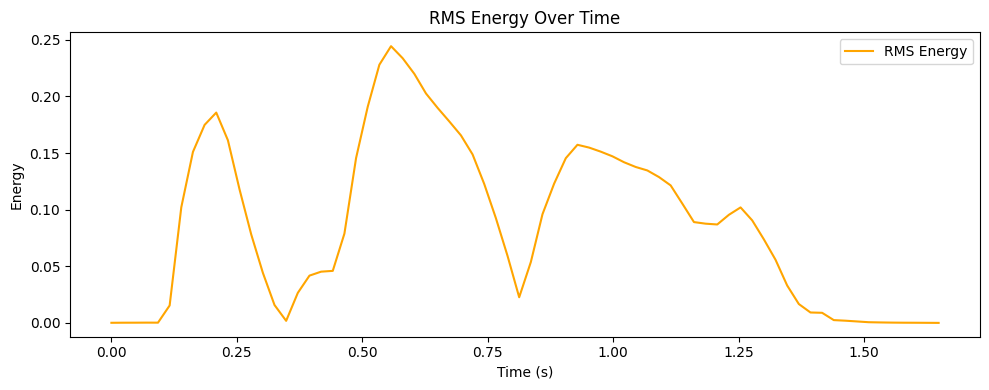

In [34]:
plt.figure(figsize=(10, 4))
plt.plot(t, rms, label='RMS Energy', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.title('RMS Energy Over Time')
plt.legend()
plt.tight_layout()
plt.show()

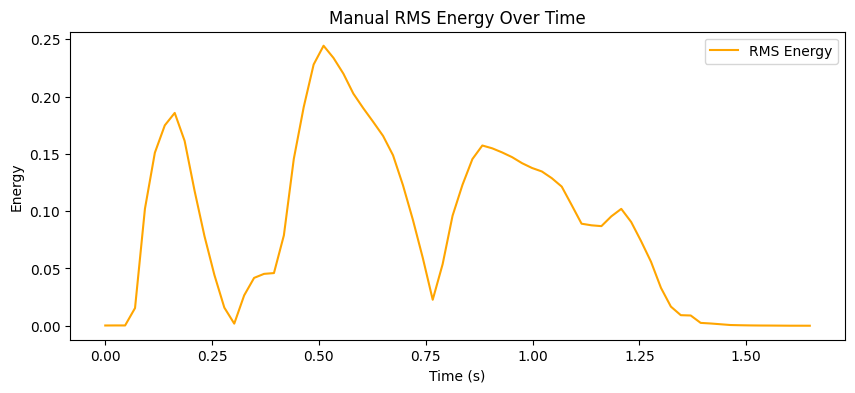

In [35]:
def manual_rms(y, frame_length=2048, hop_length=512):
    # Mirip librosa.feature.rms
    y = np.pad(y, (0, frame_length - len(y) % hop_length), mode='constant')
    n_frames = 1 + (len(y) - frame_length) // hop_length
    rms = np.empty(n_frames)
    for i in range(n_frames):
        start = i * hop_length
        frame = y[start:start + frame_length]
        rms[i] = np.sqrt(np.mean(frame**2))
    return rms

# Manual RMS calculation
rms_manual = manual_rms(x)
frames = range(len(rms_manual))
t = librosa.frames_to_time(frames, sr=sr, hop_length=512)

plt.figure(figsize=(10, 4))
plt.plot(t, rms_manual, label='RMS Energy', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.title('Manual RMS Energy Over Time')
plt.legend()

# Final Preprocessing on Data

### Audio Preprocessing

In [36]:
SAMPLE_RATE = 16000 # Standard rate for speech models
DURATION = 3 # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [40]:
def PreprocessAudio(file_path):
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        
        # trim silence
        y, _ = librosa.effects.trim(y)
        
        # reduce noise
        y = nr.reduce_noise(y=y, sr=sr)
        
        # normalize
        y = librosa.util.normalize(y)

        # padding/truncating
        if len(y) < SAMPLES_PER_TRACK:
            y = np.pad(y, (0, SAMPLES_PER_TRACK - len(y)))
        else:
            y = y[:SAMPLES_PER_TRACK]

        return y, sr
    except Exception as error:
        print(f"Failed to process '{file_path}': {error}")
        return None, None

In [37]:
SAMPLE_RATE = 16000 # Standard rate for speech models
DURATION = 3 # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [38]:
def PreprocessAudioManual(file_path):
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        
        # 1. Trim silence (manual)
        y = manual_trim_silence(y, threshold=0.01)
        
        # 2. Noise reduction (manual)
        y = manual_spectral_gating(y, sr)
        
        # 3. Normalize (manual)
        y = manual_normalize_audio(y)
        
        # 4. Padding/truncating
        if len(y) < SAMPLES_PER_TRACK:
            y = np.pad(y, (0, SAMPLES_PER_TRACK - len(y)))
        else:
            y = y[:SAMPLES_PER_TRACK]

        return y, sr
    except Exception as error:
        print(f"Failed to process '{file_path}': {error}")
        return None, None

### Feature Extraction

In [ ]:
def ExtractAudioFeatures(file_path):
    audio_signal, sample_rate = PreprocessAudio(file_path)
    if audio_signal is None:
        return None

    n_fft = 2048  # means 2048 samples per window (~128ms if sr=16k)
    hop_length = 512  # means we move 512 samples forward for next window (~32ms)
    
    mfcc = librosa.feature.mfcc(y=audio_signal, sr=sample_rate, n_mfcc=13, hop_length=hop_length, n_fft=n_fft)
    mfcc_mean = np.mean(mfcc, axis=1)

    rolloff = librosa.feature.spectral_rolloff(y=audio_signal, sr=sample_rate, hop_length=hop_length, n_fft=n_fft)[0]
    rolloff_mean = np.mean(rolloff)

    zcr = librosa.feature.zero_crossing_rate(y=audio_signal, hop_length=hop_length)[0]
    zcr_mean = np.mean(zcr)

    centroid = librosa.feature.spectral_centroid(y=audio_signal, sr=sample_rate, hop_length=hop_length, n_fft=n_fft)[0]
    centroid_mean = np.mean(centroid)

    rms = librosa.feature.rms(y=audio_signal, hop_length=hop_length)[0]
    rms_mean = np.mean(rms)

    combined_features = np.hstack([
        mfcc_mean,
        rolloff_mean,
        zcr_mean,
        centroid_mean,
        rms_mean
    ])

    return combined_features

In [39]:
def ExtractAudioFeaturesManual(file_path):
    audio_signal, sample_rate = PreprocessAudioManual(file_path)
    if audio_signal is None:
        return None

    n_fft = 2048
    hop_length = 512

    # Manual MFCC
    mfcc = manual_mfcc(audio_signal, sample_rate, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)
    # Manual Spectral Rolloff
    rolloff = manual_spectral_rolloff(audio_signal, sample_rate, n_fft=n_fft, hop_length=hop_length)
    rolloff_mean = np.mean(rolloff)

    # Manual Zero Crossing Rate
    def manual_zcr(y, frame_length=2048, hop_length=512):
        y = np.pad(y, (0, frame_length - len(y) % hop_length), mode='constant')
        n_frames = 1 + (len(y) - frame_length) // hop_length
        zcr = np.empty(n_frames)
        for i in range(n_frames):
            start = i * hop_length
            frame = y[start:start + frame_length]
            signs = np.sign(frame)
            zcr[i] = np.sum(np.abs(np.diff(signs))) / 2 / frame_length
        return zcr
    zcr = manual_zcr(audio_signal, frame_length=n_fft, hop_length=hop_length)
    zcr_mean = np.mean(zcr)

    # Manual Spectral Centroid
    stft_matrix = manual_stft(audio_signal, frame_size=n_fft, hop_length=hop_length)
    centroid = manual_spectral_centroid(stft_matrix, sample_rate)
    centroid_mean = np.mean(centroid)

    # Manual RMS
    rms = manual_rms(audio_signal, frame_length=n_fft, hop_length=hop_length)
    rms_mean = np.mean(rms)

    combined_features = np.hstack([
        mfcc_mean,
        mfcc_std,
        rolloff_mean,
        zcr_mean,
        centroid_mean,
        rms_mean
    ])


    return combined_features

# Load Data

In [40]:
male_folder = 'data/male/'
female_folder = 'data/female/'

In [41]:
data = []
labels = []

In [46]:
def process_male_file(file_path):
    features = ExtractAudioFeatures(file_path)
    if features is not None:
        return (features, 'male')
    return None

In [47]:
male_folder = 'data/male/'
female_folder = 'data/female/'

In [48]:
data = []
labels = []

Since the two folders are large (`male_folder` contains 10.5k files), we will use parallel processing to speed up the process 

In [ ]:
import concurrent.futures
from tqdm import tqdm

# get all file paths first
file_paths = [os.path.join(male_folder, f) for f in os.listdir(male_folder) if os.path.isfile(os.path.join(male_folder, f))]

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_male_file, file_paths), total=len(file_paths)))

for result in results:
    if result is not None:
        features, label = result
        data.append(features)
        labels.append(label)

100%|██████████| 10380/10380 [09:58<00:00, 17.34it/s]


In [42]:
def process_male_file(file_path):
    features = ExtractAudioFeaturesManual(file_path)
    if features is not None:
        return (features, 'male')
    return None

import concurrent.futures
from tqdm import tqdm

file_paths = [os.path.join(male_folder, f) for f in os.listdir(male_folder) if os.path.isfile(os.path.join(male_folder, f))]

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_male_file, file_paths), total=len(file_paths)))

for result in results:
    if result is not None:
        features, label = result
        data.append(features)
        labels.append(label)

100%|██████████| 10380/10380 [1:25:58<00:00,  2.01it/s] 


In [ ]:
def process_female_file(file_path):
    features = ExtractAudioFeatures(file_path)
    if features is not None:
        return (features, 'female')
    return None

In [ ]:
file_paths = [os.path.join(female_folder, f) for f in os.listdir(female_folder) if os.path.isfile(os.path.join(female_folder, f))]

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_female_file, file_paths), total=len(file_paths)))

for result in results:
    if result is not None:
        features, label = result
        data.append(features)
        labels.append(label)

100%|██████████| 5768/5768 [05:35<00:00, 17.17it/s]


In [43]:
def process_female_file(file_path):
    features = ExtractAudioFeaturesManual(file_path)
    if features is not None:
        return (features, 'female')
    return None

file_paths = [os.path.join(female_folder, f) for f in os.listdir(female_folder) if os.path.isfile(os.path.join(female_folder, f))]

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_female_file, file_paths), total=len(file_paths)))

for result in results:
    if result is not None:
        features, label = result
        data.append(features)
        labels.append(label)

100%|██████████| 5768/5768 [24:14<00:00,  3.97it/s]  


Now that we loaded our two folders, we can create our dataframe

In [44]:
df = pd.DataFrame(data)
df['gender'] = labels

In [45]:
feature_columns = ([f"mfcc_{i+1}" for i in range(26)] +["spectral_rolloff", "zero_crossing_rate", "spectral_centroid", "rms"])

df.columns = feature_columns + ['gender']

df = df.sample(frac=1).reset_index(drop=True)

df.head()

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,mfcc_22,mfcc_23,mfcc_24,mfcc_25,mfcc_26,spectral_rolloff,zero_crossing_rate,spectral_centroid,rms,gender
0,-179.105549,85.344146,43.202780,9.651403,-6.660635,-7.573095,-1.418584,0.081507,-2.293636,-2.566311,...,7.650406,6.523385,6.526455,6.759197,5.887955,316.319444,0.022869,270.027719,0.127591,male
1,-160.448856,95.420720,19.142343,-22.421716,-19.382291,-7.226945,-7.422683,-5.422703,-2.006355,-5.359519,...,8.408482,7.733035,5.423243,5.355150,6.420517,626.388889,0.060762,480.867860,0.169596,female
2,-174.736675,82.411338,23.452622,-5.385339,-11.900555,-6.778393,-3.137408,-6.066697,-7.159228,3.853530,...,11.502089,8.553319,8.543942,10.471239,8.585505,552.517361,0.057376,433.317190,0.113531,male
3,-186.411486,67.492038,15.591105,0.549230,-6.448704,-10.722610,-4.825625,-4.521891,-4.810713,-0.238349,...,8.645947,7.922482,4.463442,8.976438,6.583641,545.746528,0.049290,465.294813,0.080626,male
4,-205.061059,59.176056,33.396552,10.276456,-2.441219,-6.081706,-4.925023,-3.008138,-2.221908,-2.371621,...,5.835862,4.642442,5.456135,4.625895,3.224638,139.930556,0.009927,132.571409,0.113205,male


# EDA & Preprocessing

Now let's explore our constructed data

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16148 entries, 0 to 16147
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mfcc_1              16148 non-null  float64
 1   mfcc_2              16148 non-null  float64
 2   mfcc_3              16148 non-null  float64
 3   mfcc_4              16148 non-null  float64
 4   mfcc_5              16148 non-null  float64
 5   mfcc_6              16148 non-null  float64
 6   mfcc_7              16148 non-null  float64
 7   mfcc_8              16148 non-null  float64
 8   mfcc_9              16148 non-null  float64
 9   mfcc_10             16148 non-null  float64
 10  mfcc_11             16148 non-null  float64
 11  mfcc_12             16148 non-null  float64
 12  mfcc_13             16148 non-null  float64
 13  mfcc_14             16148 non-null  float64
 14  mfcc_15             16148 non-null  float64
 15  mfcc_16             16148 non-null  float64
 16  mfcc

In [47]:
print("Data Shape:", df.shape)

Data Shape: (16148, 31)


In [48]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mfcc_1,16148.0,-179.592966,17.364115,-240.797252,-190.808973,-176.892535,-166.770630,-131.247777
mfcc_2,16148.0,71.113300,16.073304,12.253728,60.526187,73.965150,83.688708,105.826226
mfcc_3,16148.0,21.591175,11.499188,-18.299373,13.422018,21.356785,29.544073,68.358601
mfcc_4,16148.0,-1.142965,8.973848,-34.747894,-7.194712,-1.099778,4.919992,34.545709
mfcc_5,16148.0,-7.869357,5.431701,-32.328189,-11.569552,-7.737387,-3.968147,10.616862
mfcc_6,16148.0,-8.990534,5.458954,-34.163103,-12.358372,-8.568507,-5.153481,9.574448
mfcc_7,16148.0,-9.035880,5.329846,-35.824821,-12.162917,-8.569066,-5.353804,7.125144
mfcc_8,16148.0,-6.240158,4.097958,-24.070703,-8.812991,-6.085211,-3.479070,16.291702
mfcc_9,16148.0,-3.656329,3.516980,-21.620014,-5.869190,-3.636523,-1.410650,12.969859
mfcc_10,16148.0,-1.677792,3.501089,-15.481705,-3.966735,-1.678567,0.624427,12.432726


## Null Values

In [49]:
df.isna().sum()

mfcc_1                0
mfcc_2                0
mfcc_3                0
mfcc_4                0
mfcc_5                0
mfcc_6                0
mfcc_7                0
mfcc_8                0
mfcc_9                0
mfcc_10               0
mfcc_11               0
mfcc_12               0
mfcc_13               0
mfcc_14               0
mfcc_15               0
mfcc_16               0
mfcc_17               0
mfcc_18               0
mfcc_19               0
mfcc_20               0
mfcc_21               0
mfcc_22               0
mfcc_23               0
mfcc_24               0
mfcc_25               0
mfcc_26               0
spectral_rolloff      0
zero_crossing_rate    0
spectral_centroid     0
rms                   0
gender                0
dtype: int64

## Exploring Duplicates

In [50]:
print("Number of Duplicates:", df.duplicated().sum())
print(f"Percentage of Duplicates: {df.duplicated().sum() / len(df) * 100:.2f}%")

Number of Duplicates: 1562
Percentage of Duplicates: 9.67%


In [51]:
df = df.drop_duplicates()
print("Dropped Duplicates")
print(f"Percentage of Duplicates: {df.duplicated().sum() / len(df) * 100:.2f}%")
print("Data Shape:", df.shape)

Dropped Duplicates
Percentage of Duplicates: 0.00%
Data Shape: (14586, 31)


## Examining Class Imbalance

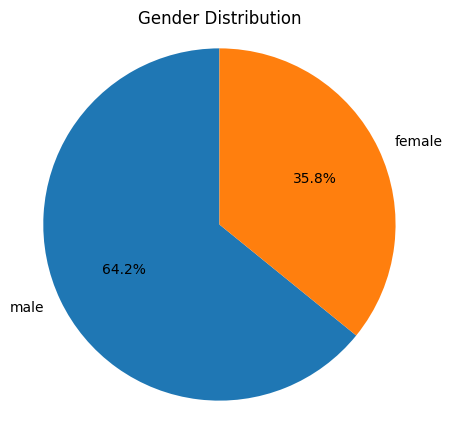

In [52]:
gender_counts = df['gender'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution')
plt.axis('equal')
plt.show()

We see here that we have a class imbalance in our target variable

To resolve this issue, we will assign weights to each of them in training phase

### Data Distribution

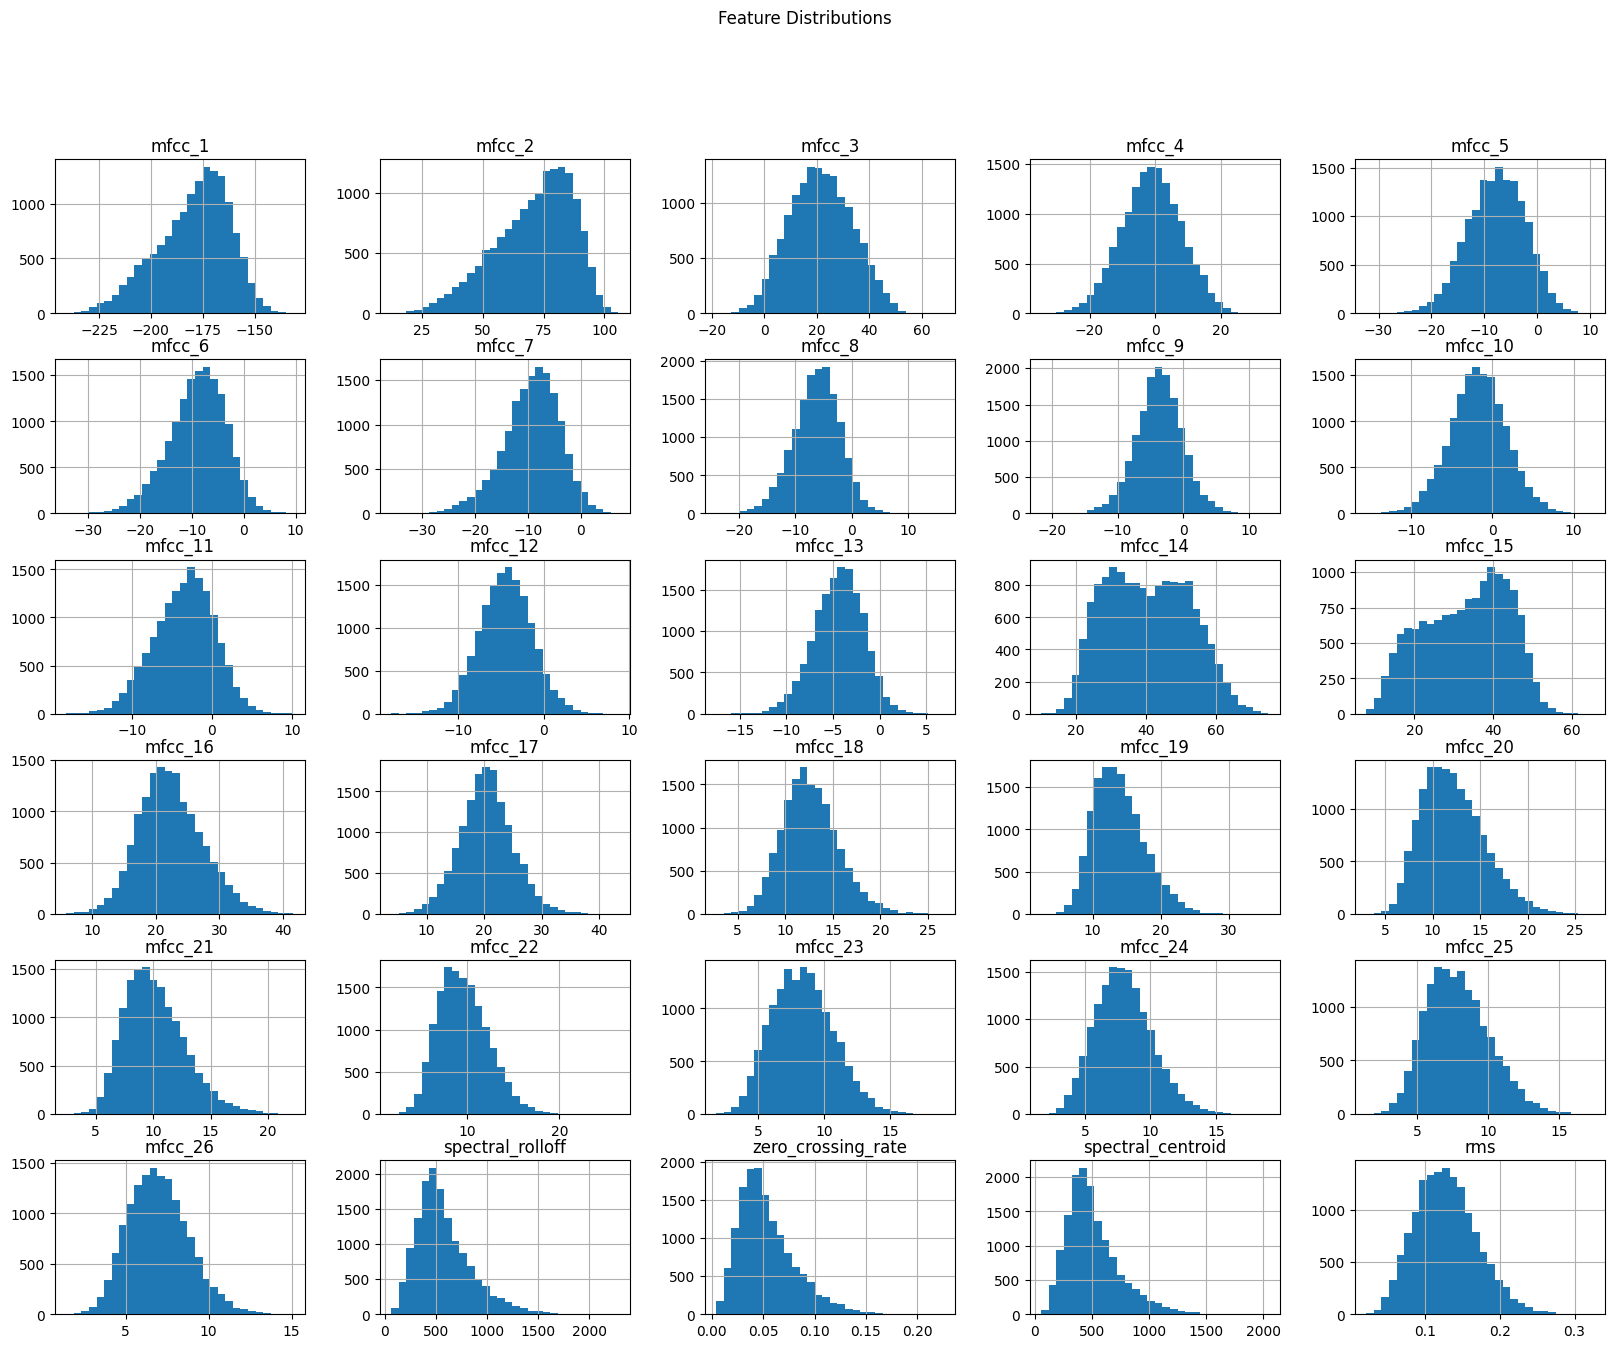

In [53]:
feature_columns = df.columns[:-1]
df[feature_columns].hist(bins=30, figsize=(20, 15))
plt.suptitle('Feature Distributions')
plt.show()

## Handling Outliers

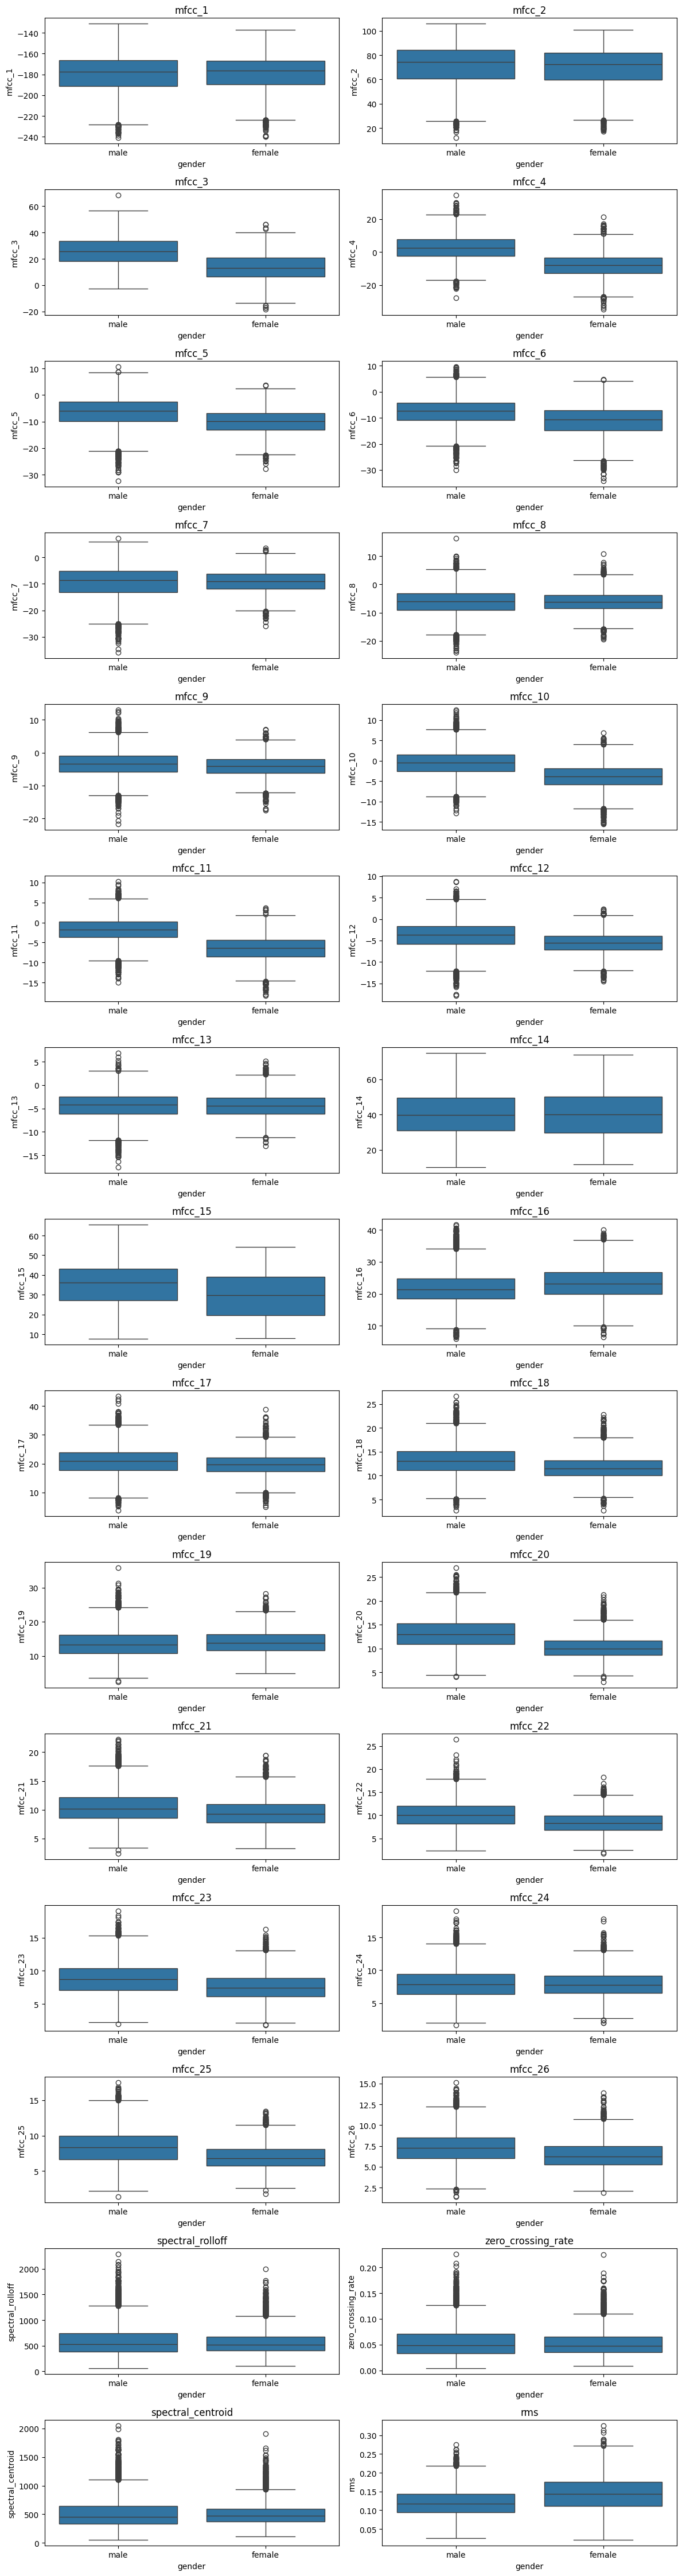

In [54]:
n = len(feature_columns)

rows = (n + 1) // 2
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

for i, col in enumerate(feature_columns):
    sns.boxplot(x='gender', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col}')

# Hide any unused plots
for j in range(len(feature_columns), len(axes)):
    fig.delaxes(axes[j])  # <-- perbaikan di sini

plt.tight_layout()
plt.show()

In [55]:
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()

Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[~((df[numerical_columns] < lower_bound) | 
          (df[numerical_columns] > upper_bound)).any(axis=1)]


## Categorical Encoding

In [56]:
df['gender'] = df['gender'].map({
    'male': 1,
    'female': 0
})

In [57]:
df.head()

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,mfcc_22,mfcc_23,mfcc_24,mfcc_25,mfcc_26,spectral_rolloff,zero_crossing_rate,spectral_centroid,rms,gender
0,-179.105549,85.344146,43.202780,9.651403,-6.660635,-7.573095,-1.418584,0.081507,-2.293636,-2.566311,...,7.650406,6.523385,6.526455,6.759197,5.887955,316.319444,0.022869,270.027719,0.127591,1
1,-160.448856,95.420720,19.142343,-22.421716,-19.382291,-7.226945,-7.422683,-5.422703,-2.006355,-5.359519,...,8.408482,7.733035,5.423243,5.355150,6.420517,626.388889,0.060762,480.867860,0.169596,0
2,-174.736675,82.411338,23.452622,-5.385339,-11.900555,-6.778393,-3.137408,-6.066697,-7.159228,3.853530,...,11.502089,8.553319,8.543942,10.471239,8.585505,552.517361,0.057376,433.317190,0.113531,1
3,-186.411486,67.492038,15.591105,0.549230,-6.448704,-10.722610,-4.825625,-4.521891,-4.810713,-0.238349,...,8.645947,7.922482,4.463442,8.976438,6.583641,545.746528,0.049290,465.294813,0.080626,1
4,-205.061059,59.176056,33.396552,10.276456,-2.441219,-6.081706,-4.925023,-3.008138,-2.221908,-2.371621,...,5.835862,4.642442,5.456135,4.625895,3.224638,139.930556,0.009927,132.571409,0.113205,1


In [58]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mfcc_1,11723.0,-181.732459,16.432165,-226.705199,-193.113678,-179.705652,-169.363761,-138.497017
mfcc_2,11723.0,70.796657,15.750451,26.126248,59.825032,73.499320,83.312550,105.826226
mfcc_3,11723.0,21.138681,11.455607,-12.208299,12.856883,20.736378,29.021950,55.056685
mfcc_4,11723.0,-1.552794,8.771612,-25.464503,-7.588732,-1.532073,4.471210,23.242506
mfcc_5,11723.0,-7.571232,5.179504,-22.651381,-11.132912,-7.465692,-3.847512,7.407847
mfcc_6,11723.0,-8.806764,5.045675,-23.283005,-12.089552,-8.421495,-5.170641,5.779400
mfcc_7,11723.0,-8.773917,4.854660,-22.901473,-11.942766,-8.441143,-5.364626,4.622340
mfcc_8,11723.0,-6.235618,3.761942,-16.944644,-8.705788,-6.097751,-3.591906,4.696844
mfcc_9,11723.0,-3.559852,3.156915,-12.677373,-5.649028,-3.541942,-1.413414,5.458748
mfcc_10,11723.0,-1.821272,3.193205,-10.819637,-3.971645,-1.794195,0.359956,7.366846


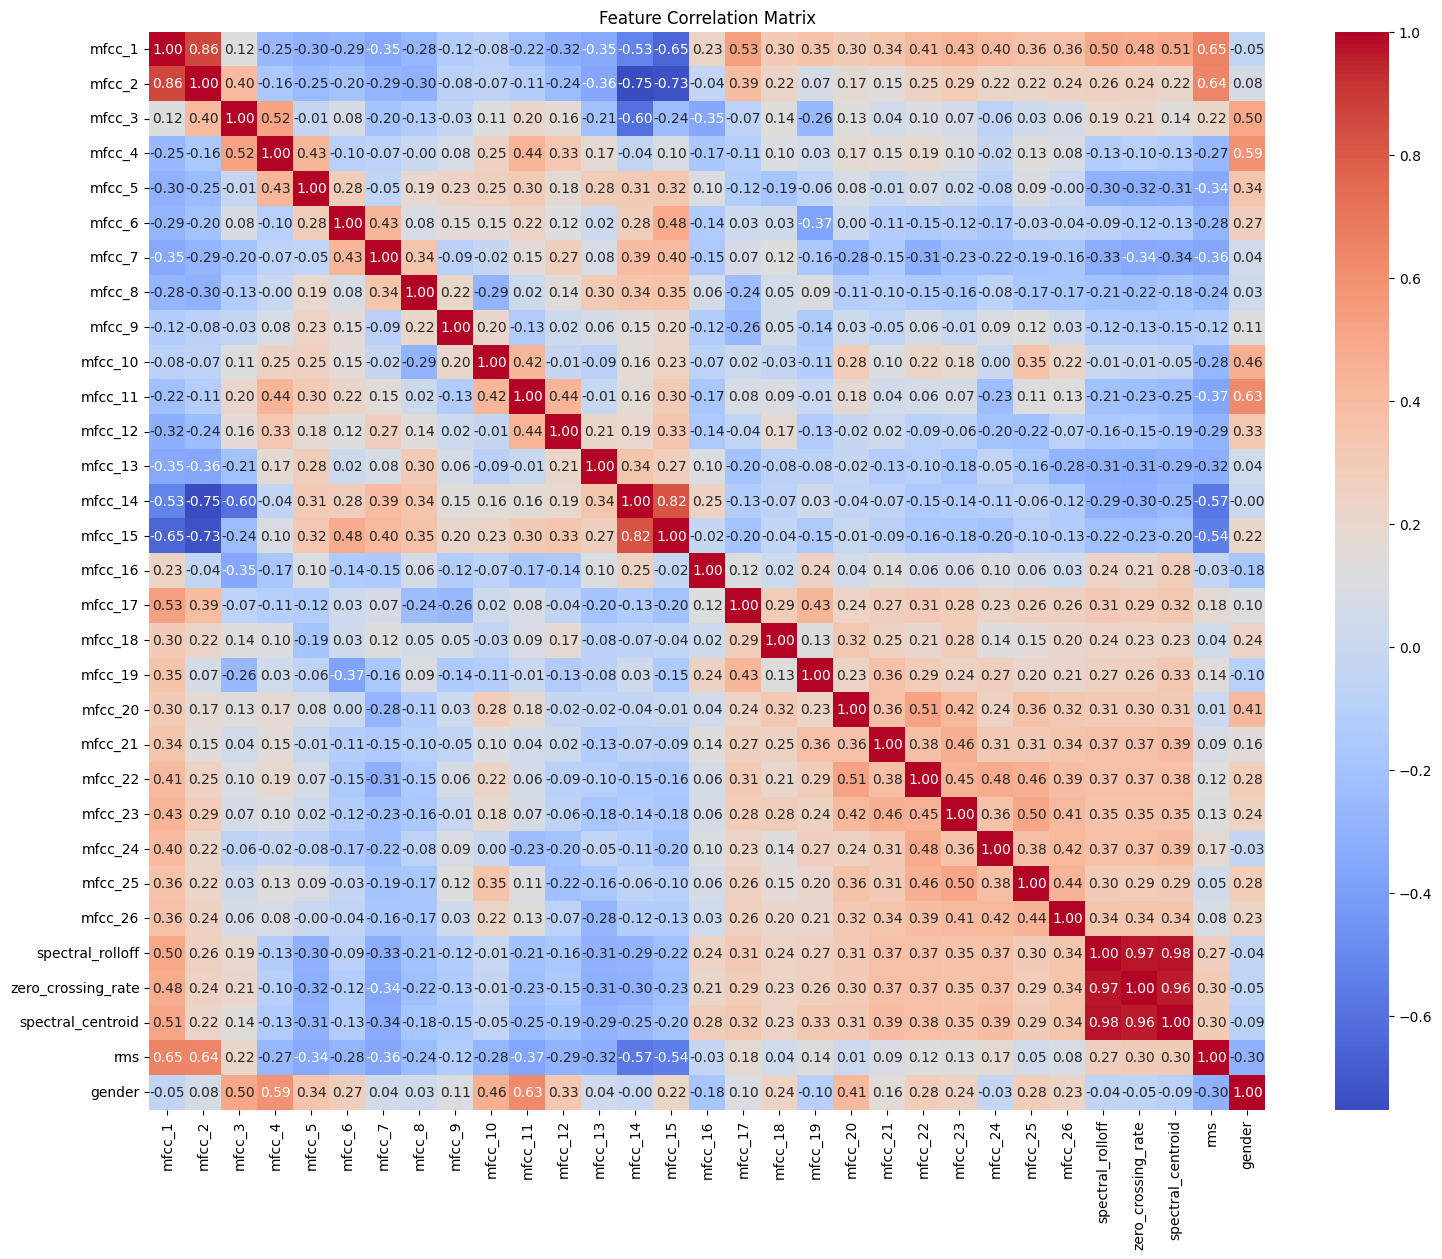

In [59]:
plt.figure(figsize=(18,14))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [60]:
df = df.drop(['mfcc_2', 'mfcc_3', 'mfcc_5', 'mfcc_6', 'mfcc_11', 'mfcc_16',
              'mfcc_21', 'mfcc_22', 'mfcc_25', 
              'spectral_rolloff', 'zero_crossing_rate'], axis=1)

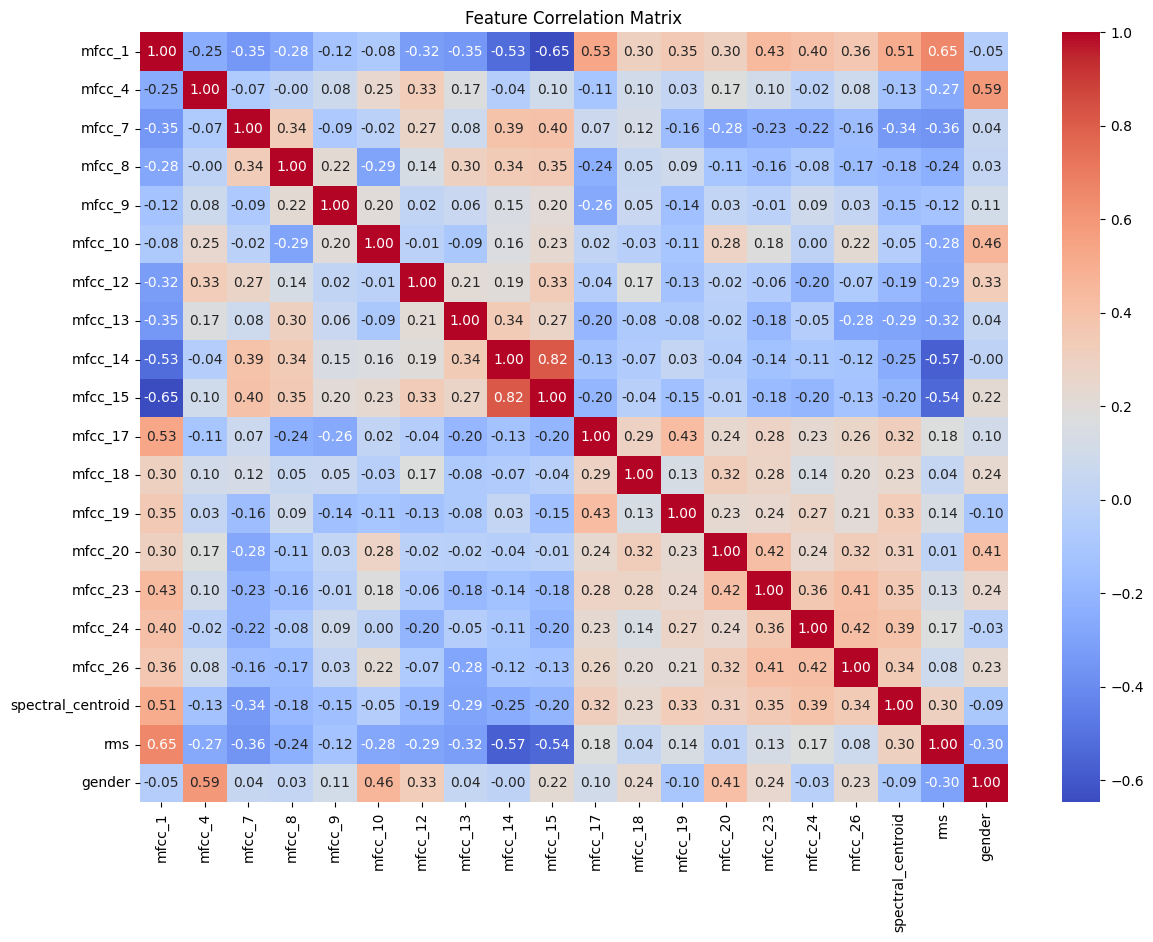

In [61]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [62]:
df.shape

(11723, 20)

# Splitting Data

In [63]:
X = df.drop(columns='gender')
y = df['gender']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 9378
Testing set size: 2345


In [65]:
# Manual train-test split (tanpa sklearn)
import numpy as np

test_size = 0.2
random_state = 42

# Pastikan X dan y adalah numpy array
X = np.array(X)
y = np.array(y)

# Set random seed untuk reproducibility
np.random.seed(random_state)

# Shuffle index
indices = np.arange(len(X))
np.random.shuffle(indices)

# Tentukan ukuran test set
n_test = int(len(X) * test_size)

# Split index
test_idx = indices[:n_test]
train_idx = indices[n_test:]

# Split data
X_train = X[train_idx]
X_test = X[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 9379
Testing set size: 2344


In [66]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [67]:
# Manual Standardization (tanpa sklearn)
import numpy as np

# Hitung mean dan std dari training set
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

# Standardisasi training dan test set
X_train = (X_train - mean) / (std + 1e-8)
X_test = (X_test - mean) / (std + 1e-8)

# Model Evaluation

In [68]:
class GaussianNaiveBayes:
    def __init__(self):
        self.ClassLabels = None
        self.ClassPriors = {}
        self.ClassMeans = {}
        self.ClassVariances = {}
        self.ClassWeights = {} # to handle class imbalance

    def Mean(self, Features):
        return np.mean(Features, axis=0)

    def Variance(self, Features, MeanValues):
        return np.var(Features, axis=0) + 1e-9

    def fit(self, Features, Labels):
        Features = np.array(Features, dtype=np.float64)
        Labels = np.array(Labels)

        self.ClassLabels = np.unique(Labels)

        for Label in self.ClassLabels:
            ClassFeatures = Features[Labels == Label]
            self.ClassPriors[Label] = len(ClassFeatures) / len(Features)
            self.ClassMeans[Label] = self.Mean(ClassFeatures)
            self.ClassVariances[Label] = self.Variance(ClassFeatures, self.ClassMeans[Label])

        total = len(Labels)
        self.ClassWeights = {label: total / (len(self.ClassLabels) * np.sum(Labels == label)) for label in self.ClassLabels}

    def CalculateGaussian(self, FeatureValues, Mean, Variance):
        expComponent = np.exp(-((FeatureValues - Mean) ** 2) / (2 * Variance))
        return (1.0 / np.sqrt(2 * np.pi * Variance)) * expComponent

    def PredictBatch(self, Features):
        Features = np.array(Features, dtype=np.float64)
        return np.array([self.PredictSingle(sample) for sample in Features])

    def PredictSingle(self, FeatureSample):
        LogPosteriors = []
        for Label in self.ClassLabels:
            PriorLog = np.log(self.ClassPriors[Label])
            ConditionalLog = np.sum(np.log(self.CalculateGaussian(FeatureSample, self.ClassMeans[Label], self.ClassVariances[Label])))
            TotalLogPosterior = PriorLog + ConditionalLog + np.log(self.ClassWeights[Label])
            LogPosteriors.append(TotalLogPosterior)
        return self.ClassLabels[np.argmax(LogPosteriors)]

    def Evaluate(self, ActualLabels, PredictedLabels):
        Accuracy = np.mean(ActualLabels == PredictedLabels)

        UniqueLabels = np.unique(ActualLabels)
        PrecisionList, RecallList, F1List = [], [], []

        for Label in UniqueLabels:
            TruePositive = np.sum((PredictedLabels == Label) & (ActualLabels == Label))
            FalsePositive = np.sum((PredictedLabels == Label) & (ActualLabels != Label))
            FalseNegative = np.sum((PredictedLabels != Label) & (ActualLabels == Label))

            Precision = TruePositive / (TruePositive + FalsePositive + 1e-9)
            Recall = TruePositive / (TruePositive + FalseNegative + 1e-9)
            F1 = 2 * Precision * Recall / (Precision + Recall + 1e-9)

            PrecisionList.append(Precision)
            RecallList.append(Recall)
            F1List.append(F1)

        return {
            'Accuracy': Accuracy,
            'Recall': np.mean(RecallList),
            'Precision': np.mean(PrecisionList),
            'F1 Score': np.mean(F1List)
        }

    
    def predict(self, X):
        return self.PredictBatch(X)

In [69]:
Model = GaussianNaiveBayes()
Model.fit(X_train, y_train)
y_pred = Model.PredictBatch(X_test)
Results = Model.Evaluate(y_test, y_pred)

print("Evaluation Results:")
print(f"Accuracy : {Results['Accuracy']:.3f}")
print(f"Precision: {Results['Precision']:.3f}")
print(f"Recall   : {Results['Recall']:.3f}")
print(f"F1 Score : {Results['F1 Score']:.3f}")

Evaluation Results:
Accuracy : 0.895
Precision: 0.888
Recall   : 0.886
F1 Score : 0.887


In [70]:
# Naiive Bayes from scratch
FromScratchModel = GaussianNaiveBayes()
FromScratchModel.fit(X_train, y_train)
FromScratchPredictions = FromScratchModel.PredictBatch(X_test)
FromScratchResults = FromScratchModel.Evaluate(y_test, FromScratchPredictions)

# Builtin GaussianNB 
SklearnModel = GaussianNB()
SklearnModel.fit(X_train, y_train)
SklearnPredictions = SklearnModel.predict(X_test)

SklearnResults = {
    'Accuracy': accuracy_score(y_test, SklearnPredictions),
    'Precision': precision_score(y_test, SklearnPredictions, average='macro'),
    'Recall': recall_score(y_test, SklearnPredictions, average='macro'),
    'F1Score': f1_score(y_test, SklearnPredictions, average='macro')
}

def DisplayResults(ModelName, Metrics):
    print(f"\n{ModelName} Performance:")
    for Metric, Value in Metrics.items():
        print(f"{Metric}: {Value:.3f}")


DisplayResults("Custom Gaussian Naive Bayes", FromScratchResults)
DisplayResults("Scikit-learn GaussianNB", SklearnResults)


Custom Gaussian Naive Bayes Performance:
Accuracy: 0.895
Recall: 0.886
Precision: 0.888
F1 Score: 0.887

Scikit-learn GaussianNB Performance:
Accuracy: 0.893
Precision: 0.890
Recall: 0.876
F1Score: 0.882


In [73]:
# Logistic Regression dengan class_weight balanced
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Logistic Regression (Single Model) Evaluation:")
print("Accuracy :", round(accuracy_score(y_test, y_pred_lr), 3))
print("Precision:", round(precision_score(y_test, y_pred_lr, average='macro'), 3))
print("Recall   :", round(recall_score(y_test, y_pred_lr, average='macro'), 3))
print("F1 Score :", round(f1_score(y_test, y_pred_lr, average='macro'), 3))

Logistic Regression (Single Model) Evaluation:
Accuracy : 0.954
Precision: 0.947
Recall   : 0.956
F1 Score : 0.951


## Bagging Ensemble

In [75]:
def BaggingEnsamble(BaseModel,Xtrain, Ytrain,Num=5):
    models=[]
    for i in range (Num):
        Xsample,Ysample =resample(Xtrain,Ytrain)
        model=BaseModel()
        model.fit(Xsample,Ysample)
        models.append(model)

    return models

def PredictEnsamble(models , X):
    predictions = []
    for model in models:
        Ypred = model.predict(X)
        predictions.append(Ypred)
    predictions = np.array(predictions).T
    FinalPredictions = [Counter(row).most_common(1)[0][0] for row in predictions]
    return FinalPredictions

from sklearn.metrics import accuracy_score, precision_score, recall_score

def Evaluate(RealY, Ypred):
    accuracy = accuracy_score(RealY, Ypred)
    precision = precision_score(RealY, Ypred, average='macro', zero_division=0)
    recall = recall_score(RealY, Ypred, average='macro', zero_division=0)
    f1 = f1_score(RealY, Ypred, average='macro', zero_division=0)

    print("Accuracy:", round(accuracy, 4))
    print("Precision:", round(precision, 4))
    print("Recall:", round(recall, 4))
    print("F1 Score:", round(f1, 4))

In [76]:
NB_models = BaggingEnsamble(GaussianNaiveBayes, X_train, y_train)
y_pred_NB = PredictEnsamble(NB_models, X_test)
LR_models = BaggingEnsamble(lambda: LogisticRegression(max_iter=1000), X_train, y_train)
y_pred_LR = PredictEnsamble(LR_models, X_test)


print(' Gaussian Naïve Bayes :')
Evaluate(y_test, y_pred_NB)
print('\nLogistic Regression :')
Evaluate(y_test, y_pred_LR)

 Gaussian Naïve Bayes :
Accuracy: 0.8963
Precision: 0.8881
Recall: 0.8879
F1 Score: 0.888

Logistic Regression :
Accuracy: 0.9561
Precision: 0.9511
Recall: 0.9544
F1 Score: 0.9527
